![logo](1_bDwEvCRgrKVbLrAXEixpfA.png)
___

##### import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#from scipy import stats
%matplotlib inline 
sns.set(color_codes=True)

#bag of words model
from sklearn.feature_extraction.text import CountVectorizer

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#cross-validation
from sklearn.model_selection import cross_val_score

#visualizations
#!pip install wordcloud
from wordcloud import WordCloud
from pylab import *

#classification 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

# Step 6(e) - Classification (Food)

    a) Importing data

    b) N-Grams
        i) Unigram
       ii) Corpus Visualizations
      
    c) Train/Test Split
    
    d) Resampling
        i) Random Over Sampling
       ii) Random Under Sampling  

    e) Classification
        i) Original Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM
       ii) Over-Sampled Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM
      iii) Under-Sampled Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM

## a) Importing data

In [2]:
#import food_data.csv file
food_df = pd.read_csv("food_data.csv")

food_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(food_df.shape)
food_df.head(1)

(9494, 23)


,id,name,genre,subgenre,category,source_url,blurb,slug,goal,converted_pledged_amount,...,country,currency,backers_count,disable_communication,is_starrable,spotlight,staff_pick,state,success_percentage,blurb_corpus
0,1320153611,End of the Vine: Wine Arbitrage,Drinks,food,"{""id"":307,""name"":""Drinks"",""slug"":""food/drinks""...",https://www.kickstarter.com/discover/categorie...,Drink fine wine for less - we'll do the work.,end-of-the-vine-wine-arbitrage,25000,61370,...,US,USD,35,0,0,1,0,successful,245.48,drink fine wine le work


In [3]:
#locate NaN
is_NaN = food_df.isna()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = food_df[row_has_NaN]

#remove NaN
food_df = food_df.dropna()
print(food_df.isna().sum())
print(food_df.shape)

id                          0
name                        0
genre                       0
subgenre                    0
category                    0
source_url                  0
blurb                       0
slug                        0
goal                        0
converted_pledged_amount    0
created_at                  0
launched_at                 0
deadline                    0
country                     0
currency                    0
backers_count               0
disable_communication       0
is_starrable                0
spotlight                   0
staff_pick                  0
state                       0
success_percentage          0
blurb_corpus                0
dtype: int64
(9493, 23)


In [4]:
food_df.reset_index(drop=True,inplace=True)

## b) N-Grams

##### i) Unigrams 

In [5]:
#entire corpus series into seperate strings
corpus_series = food_df['blurb_corpus'].apply(lambda x: str(x))
print(type(corpus_series[0]))

print(len(corpus_series))
corpus_series

<class 'str'>
9493


0                                 drink fine wine le work
1       help make stockton next beer destination suppo...
2       crafting spectacular wine using grape many und...
3       racine brewing company newest nano brewery rac...
4       raising honey bee leasing farmer crop pollinat...
                              ...                        
9488    craft excellent coffee educate curious champio...
9489    mobile kitchen challenged young adult reveal u...
9490    local chef jay stone gearing launch korean ins...
9491    starting hot sauce company ground using native...
9492    electric mobile farm stand transporting vegeta...
Name: blurb_corpus, Length: 9493, dtype: object

In [6]:
#getting unigrams  
vectorizer = CountVectorizer() 
X1 = vectorizer.fit_transform(corpus_series)  
features = (vectorizer.get_feature_names()) 

#applying TFIDF for unigrams
vectorizer = TfidfVectorizer() 
X2 = vectorizer.fit_transform(corpus_series) 
scores = (X2.toarray()) 

In [7]:
#getting top-ranking features 
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
uni_ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
uni_words = (uni_ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", uni_words.head(20)) 



Words : 
              term        rank
3807         food  254.694557
4575         help  190.953429
1941       coffee  176.249003
2034    community  133.312316
6667          new  132.298721
5816        local  125.493892
6625         need  117.821950
3542         farm  112.726568
847          beer  110.835820
6978      organic  108.220626
10135       truck  107.195082
5993         make  103.657901
2634    delicious   98.158507
3894         free   97.649041
9035        small   92.944518
10574        want   91.402268
3912        fresh   90.285562
3698        first   88.416630
8244   restaurant   87.473606
2323        craft   87.343054


##### ii) Corpus Visualizations

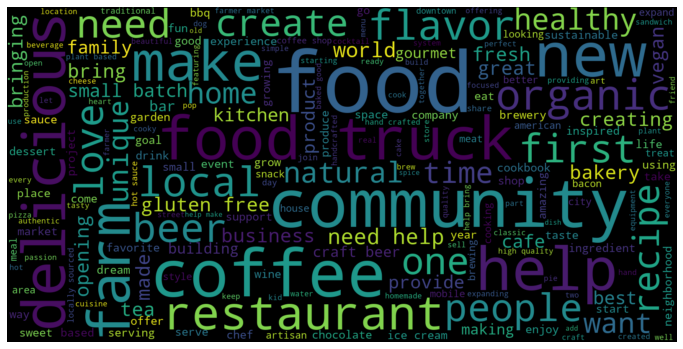

In [8]:
corpus_all = ' '.join(food_df['blurb_corpus'])

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(corpus_all)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 300 words')

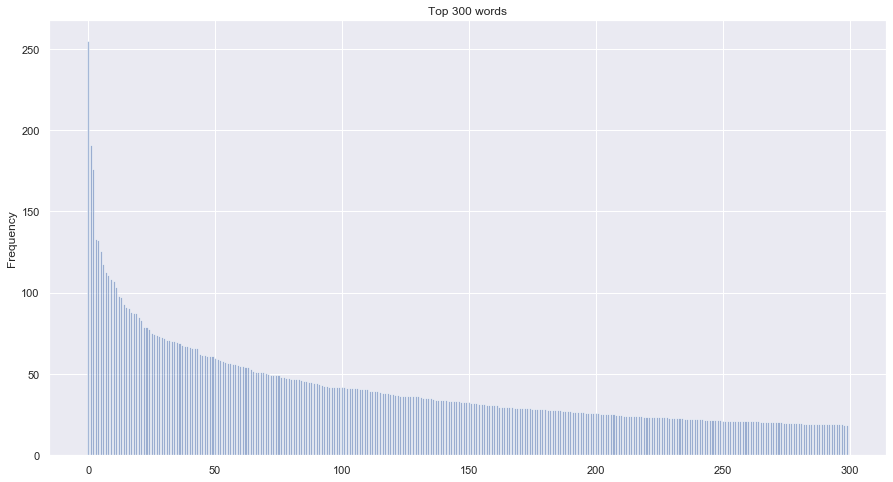

In [9]:
y_pos = np.arange(300)
plt.figure(figsize=(15,8))
plt.bar(y_pos, uni_ranking.sort_values(by='rank', ascending=False)['rank'][:300], align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 300 words')

## c) Train/Test Split

In [10]:
msk = np.random.rand(len(food_df)) < 0.75

train_df = food_df[msk]
test_df = food_df[~msk]

In [11]:
print(len(test_df))
print(len(train_df))

2367
7126


In [12]:
#split test into X_test and y_test for later
y_test = test_df['state']
X_test = test_df.drop('state',axis=1)

## d) Resampling

In [13]:
#change successful:1 / failed:0 in state column (y-dependent-variable)
print(train_df['state'].unique())
train_df.state.replace(['successful', 'failed'], [1, 0], inplace=True)
print(train_df['state'].unique())

['successful' 'failed']
[1 0]


C:\Users\vlad_\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [14]:
#change successful:1 / failed:0 in state column (y-dependent-variable)
print(test_df['state'].unique())
test_df.state.replace(['successful', 'failed'], [1, 0], inplace=True)
print(test_df['state'].unique())

['successful' 'failed']
[1 0]


In [15]:
train_df['state'].value_counts()

0    3803
1    3323
Name: state, dtype: int64

In [16]:
#class count
count_class_0, count_class_1  = train_df.state.value_counts()

#divide by class
df_class_0 = train_df[train_df['state'] == 0]
df_class_1 = train_df[train_df['state'] == 1]

##### i) Random Over-Sampling

Random over-sampling:
1    3803
0    3803
Name: state, dtype: int64


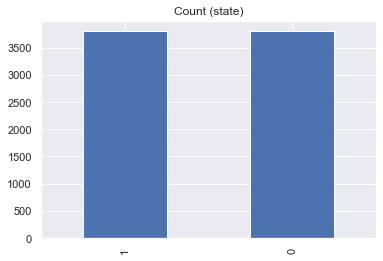

In [17]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_1_over, df_class_0], axis=0)

print('Random over-sampling:')
print(df_test_over.state.value_counts())

df_test_over.state.value_counts().plot(kind='bar', title='Count (state)')

##### ii) Random under-sampling

Random under-sampling:
1    3323
0    3323
Name: state, dtype: int64


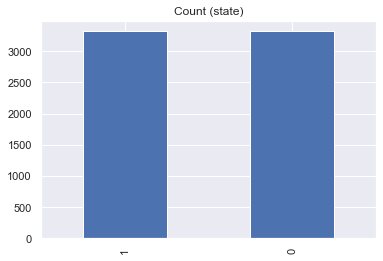

In [18]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
df_test_under['state'].value_counts()
print('Random under-sampling:')
print(df_test_under.state.value_counts())

df_test_under.state.value_counts().plot(kind='bar', title='Count (state)')

## e) Classification (Original data, Oversampled data, Undersampled data)

The following lines will include classification algorithms using 3 types of data: the original data with outliers removed, oversampled data, and undersampled data.

### i) Original data

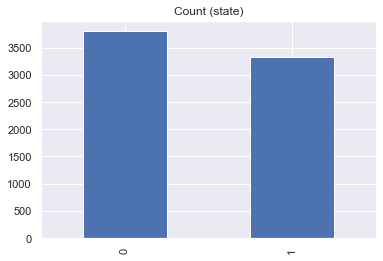

In [37]:
train_df.state.value_counts().plot(kind='bar', title='Count (state)')

In [38]:
#split into X_train and y_train
y_train = train_df['state']
X_train = train_df.drop('state',axis=1)

In [39]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_train['blurb_corpus'])
X_vec_train.shape

(7126, 53891)

In [40]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_tfidf.shape

(7126, 53891)

In [41]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(2367, 53891)

In [42]:
#apply TDIDF on test set
test_tfidf = tfidf_transformer.transform(X_vec_test)
test_tfidf.shape

(2367, 53891)

##### Naive Bayes Classifier

In [43]:
#fitting Naive Bayes Classifier to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = nb_classifier.predict(test_tfidf)

Confusion matrix:
 [[895 342]
 [419 711]]


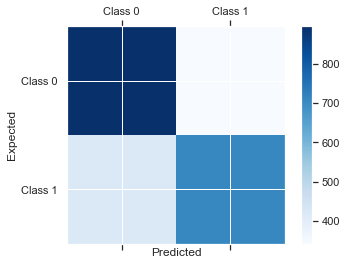

In [44]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [45]:
accText = 'Naive Bayes, Food Original'

In [46]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 67.85%
 Precision: 67.52%
    Recall: 62.92%
  F1 score: 65.14%
 ROC score: 67.64%


In [47]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier

In [48]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = reg_classifier.predict(test_tfidf)

Confusion matrix:
 [[993 244]
 [476 654]]


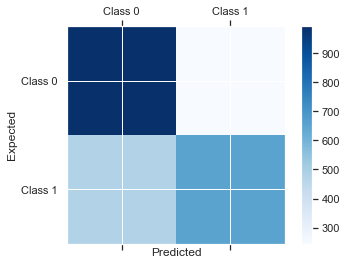

In [49]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [50]:
accText = 'Logistic Regression, Food Original'

In [51]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 69.58%
 Precision: 72.83%
    Recall: 57.88%
  F1 score: 64.50%
 ROC score: 69.08%


In [52]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [53]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 30, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_tfidf, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 1


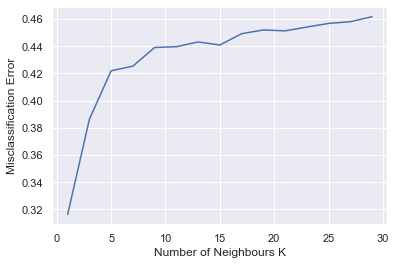

In [54]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [75]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 4, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = knn_classifier.predict(test_tfidf)

Confusion matrix:
 [[665 572]
 [304 826]]


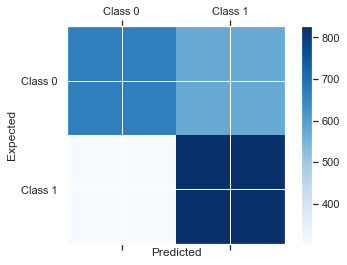

In [76]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [77]:
accText = 'KNN, Food Original'

In [78]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 62.99%
 Precision: 59.08%
    Recall: 73.10%
  F1 score: 65.35%
 ROC score: 63.43%


In [79]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [80]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='perceptron', penalty='l2')
svm_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = svm_classifier.predict(test_tfidf)

Confusion matrix:
 [[827 410]
 [410 720]]


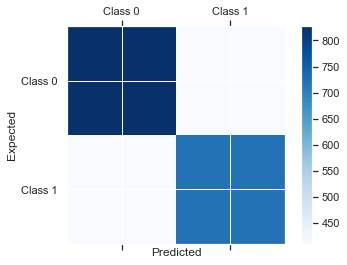

In [81]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [82]:
accText = 'SVM, Food Original'

In [83]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 65.36%
 Precision: 63.72%
    Recall: 63.72%
  F1 score: 63.72%
 ROC score: 65.29%


In [84]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

### ii) Over-sampled data

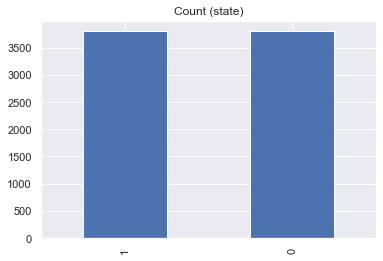

In [85]:
df2_test_over = pd.DataFrame(df_test_over)
df2_test_over.state.value_counts().plot(kind='bar', title='Count (state)')

In [86]:
#split into X_train and y_train
X_over_train = df2_test_over.drop('state',axis=1)
y_over_train = df2_test_over['state']

In [87]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_over_train['blurb_corpus'])
X_vec_train.shape

(7606, 48931)

In [88]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_over_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_over_tfidf.shape

(7606, 48931)

In [89]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(2367, 48931)

In [90]:
#apply TDIDF on test set
test_over_tfidf = tfidf_transformer.transform(X_vec_test)
test_over_tfidf.shape

(2367, 48931)

##### Naive Bayes Classifier

In [91]:
#fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = nb_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[805 432]
 [447 683]]


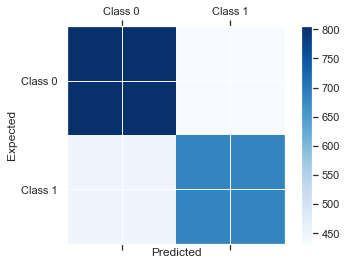

In [92]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [93]:
accText = 'Naive Bayes, Food Oversampling'

In [94]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 62.86%
 Precision: 61.26%
    Recall: 60.44%
  F1 score: 60.85%
 ROC score: 62.76%


In [95]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier

In [96]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = reg_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[985 252]
 [576 554]]


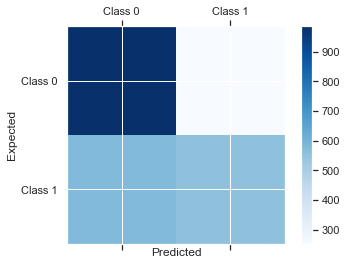

In [97]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [98]:
accText = 'Logistic Regression, Food Oversampling'

In [99]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 65.02%
 Precision: 68.73%
    Recall: 49.03%
  F1 score: 57.23%
 ROC score: 64.33%


In [100]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [101]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 30, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_over_tfidf, y_over_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 5


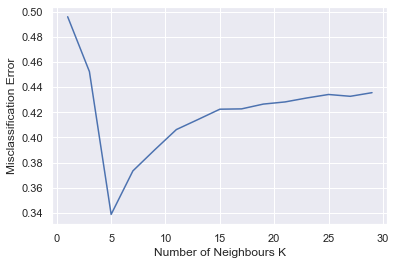

In [102]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [103]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = knn_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[824 413]
 [474 656]]


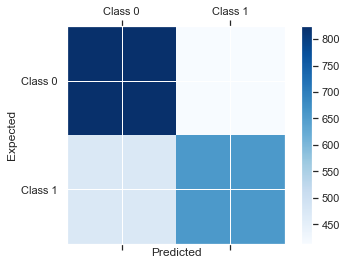

In [104]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [105]:
accText = 'KNN, Food Oversampling'

In [106]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 62.53%
 Precision: 61.37%
    Recall: 58.05%
  F1 score: 59.66%
 ROC score: 62.33%


In [107]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [112]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='log', penalty='l2')
svm_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = svm_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[971 266]
 [570 560]]


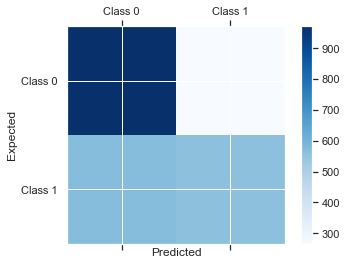

In [113]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [114]:
accText = 'SVM, Food Oversampling'

In [115]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 64.68%
 Precision: 67.80%
    Recall: 49.56%
  F1 score: 57.26%
 ROC score: 64.03%


In [116]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

### iii) Under-sampled data

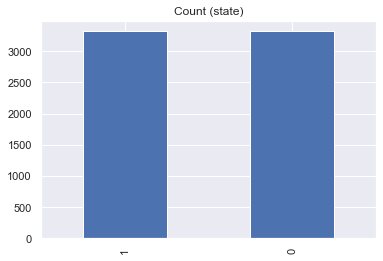

In [117]:
df2_test_under = pd.DataFrame(df_test_under)
df2_test_under.state.value_counts().plot(kind='bar', title='Count (state)')

In [118]:
#split into X_train and y_train
X_under_train = df2_test_under.drop('state',axis=1)
y_under_train = df2_test_under['state']

In [119]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_under_train['blurb_corpus'])
X_vec_train.shape

(6646, 50276)

In [120]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_under_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_under_tfidf.shape

(6646, 50276)

In [121]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(2367, 50276)

In [122]:
#apply TDIDF on test set
test_under_tfidf = tfidf_transformer.transform(X_vec_test)
test_under_tfidf.shape

(2367, 50276)

##### Naive Bayes Classifier

In [123]:
#fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = nb_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[746 491]
 [334 796]]


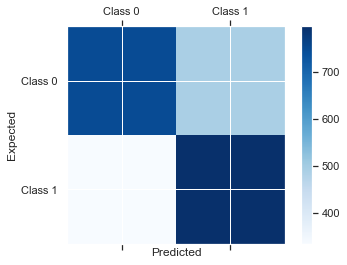

In [124]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [125]:
accText = 'Naive Bayes, Food Undersampling'

In [126]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 65.15%
 Precision: 61.85%
    Recall: 70.44%
  F1 score: 65.87%
 ROC score: 65.37%


In [127]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier


In [136]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = reg_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[805 432]
 [375 755]]


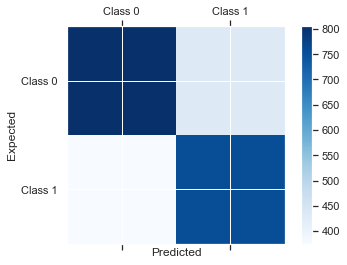

In [137]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [138]:
accText = 'Logistic Regression, Food Undersampling'

In [139]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 65.91%
 Precision: 63.61%
    Recall: 66.81%
  F1 score: 65.17%
 ROC score: 65.95%


In [140]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [141]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 35, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_under_tfidf, y_under_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 1


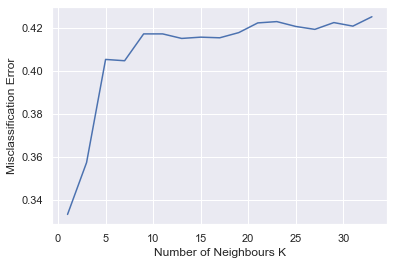

In [142]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [147]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
prediction = knn_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[564 673]
 [245 885]]


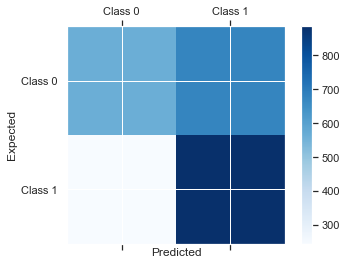

In [148]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=prediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [149]:
accText = 'KNN, Food Undersampling'

In [150]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 65.91%
 Precision: 63.61%
    Recall: 66.81%
  F1 score: 65.17%
 ROC score: 65.95%


In [151]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [157]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='log', penalty='l2')
svm_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = svm_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[802 435]
 [373 757]]


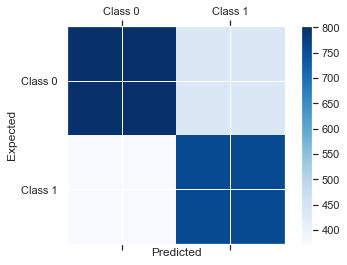

In [158]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [159]:
accText = 'SVM, Food Undersampling'

In [160]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 65.86%
 Precision: 63.51%
    Recall: 66.99%
  F1 score: 65.20%
 ROC score: 65.91%


In [161]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

## End of Step 6(e)